In [74]:
import numpy as np
import porespy as ps
import mcubes
from skimage import morphology
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [161]:
from daniela.daniela_extraction import Median3D_Array
import sys
import importlib

sys.path.insert(1, "/Users/dvarelat/Documents/MASTER/TFM/methods")
import cardiac_region

importlib.reload(cardiac_region)
import cardiac_region as c

In [13]:
FOLDERS = [
    "1_20190504_E1",
    "7_20190404_E2",
    "10_20190520_E4",
    "3_20190516_E3",
    "4_20190806_E3",
    "2_20190520_E2",
    "5_20190401_E3",
     "8_20190517_E1",
     "9_20190520_E1",
     "6_20190401_E1",
]
folder = FOLDERS[4]
print(folder)
ESPECIMEN = folder.split("_")[1] + "_" + folder.split("_")[2]

4_20190806_E3


In [14]:
gasp = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/membranes/GASP_PNAS/{ESPECIMEN}_mGFP_XYZ_predictions_GASP.nii.gz"
FILE = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/EXTRACTION/{folder}/{ESPECIMEN}_cell_properties_radiomics.csv"
file_out = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/EXTRACTION/{folder}/myo/{ESPECIMEN}_ MYOmesh.pkl"
mesh_out = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/EXTRACTION/{folder}/myo/{ESPECIMEN}_MESH.ply"

In [18]:
df_clean = pd.read_csv(FILE)
print(f"Features shape {df_clean.shape}")
# SOLO MIOCARDIO
df_clean = df_clean[df_clean.lines == 1]
print(f"Features MYOCARDIO {df_clean.shape}")
pred_mem = nib.load(gasp).get_fdata()
print(f"Segmentation shape {pred_mem.shape}")
props = ps.metrics.regionprops_3D(morphology.label(pred_mem))
print(f"LEN PROPS" {len(props)})

Features shape (5216, 64)
Features MYOCARDIO (1347, 64)
Segmentation shape (1024, 1024, 541)
LEN PROPS
7370


In [162]:
dim_info = c.load3D_metadata(gasp)

In [20]:
dict_label_cell = dict(
    zip(
        list(df_clean.original_labels),
        list(df_clean.cell_in_props),
    )
)
disk_size = 3
meshes = []
bad = []

In [179]:
for i, cell_id in enumerate(list(dict_label_cell.keys())[::20]):
    print(cell_id)
    prop = props[dict_label_cell[cell_id]]
    coords = prop.mask * 1
    add = 10
    aux = np.zeros(shape=tuple(np.asarray(coords.shape) + add), dtype="uint8")
    aux[add // 2 : -add // 2, add // 2 : -add // 2, add // 2 : -add // 2] = coords.copy()
    coords = aux.copy()
    coords = Median3D_Array(coords.copy(), disk_size)
    vert, trian = mcubes.marching_cubes(mcubes.smooth(coords), 0)
    vert -= vert.mean(axis=0)
    #vert += prop.centroid
    #vert += np.array([prop.slices[i].start for i in [0, 1, 2]])
    #vert *= np.asarray([dim_info['x_res'], dim_info['y_res'], dim_info['z_res']])
    break
vert

2791.0


array([[-5.89782955, -1.34383864, -2.55995738],
       [-5.88254061, -1.43238727, -2.55995738],
       [-5.88254061, -1.34383864, -2.61433418],
       ...,
       [ 6.61517721,  2.65616136,  0.44004262],
       [ 6.75225307,  2.65616136,  1.44004262],
       [ 6.60137107,  2.65616136,  2.44004262]])

In [106]:
cell_cords_IS = np.asarray(np.where(pred_mem == cell_id)).T
cell_cords_aux_IS = cell_cords_IS.copy()
cell_cords_IS -= cell_cords_IS.min(axis=0)
cell_cords_3d_IS = np.zeros(shape=(cell_cords_IS.max(axis=0) + 1), dtype="uint8")
for cord in cell_cords_IS:
    cell_cords_3d_IS[cord[0], cord[1], cord[2]] = 1
aux = np.zeros(shape=tuple(np.asarray(cell_cords_3d_IS.shape) + add), dtype="uint8")

In [108]:
aux[add // 2 : -add // 2, add // 2 : -add // 2, add // 2 : -add // 2] = cell_cords_3d_IS.copy()
cell_cords_3d = aux.copy()
cell_cords_3d_med = Median3D_Array(cell_cords_3d.copy(), disk_size)

In [129]:
vertices, triangles = mcubes.marching_cubes(mcubes.smooth(cell_cords_3d_med), 0)
vertices -= np.asarray([add // 2, add // 2, add // 2])
vertices

array([[-0.01528894,  6.        ,  5.        ],
       [ 0.        ,  5.91145137,  5.        ],
       [ 0.        ,  6.        ,  4.9456232 ],
       ...,
       [12.49771782, 10.        ,  8.        ],
       [12.63479368, 10.        ,  9.        ],
       [12.48391168, 10.        , 10.        ]])

In [128]:
print(prop.centroid - np.array([prop.slices[i].start for i in [0, 1, 2]]))
print(prop.centroid_local)

[5.85453161 7.27722772 7.59786748]
[5.85453161 7.27722772 7.59786748]


In [174]:
np.asarray(np.where(pred_mem[prop.slice] == cell_id)).T + np.array([prop.slices[i].start for i in [0, 1, 2]])

array([[152, 439, 174],
       [152, 440, 169],
       [152, 440, 170],
       ...,
       [165, 444, 173],
       [165, 444, 174],
       [166, 444, 174]])

In [159]:
vert

array([[151.98471106, 440.        , 169.        ],
       [152.        , 439.91145137, 169.        ],
       [152.        , 440.        , 168.9456232 ],
       ...,
       [164.49771782, 444.        , 172.        ],
       [164.63479368, 444.        , 173.        ],
       [164.48391168, 444.        , 174.        ]])

In [147]:
np.unique(pred_mem[prop.slice])

array([   0., 2087., 2126., 2127., 2241., 2329., 2543., 2791., 3258.])

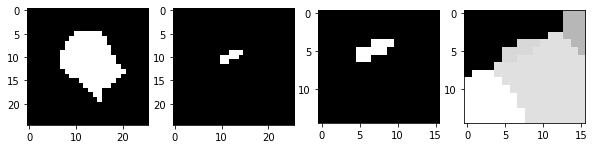

In [146]:
for t in range(16):
    plt.figure(figsize=(10,10)) 
    n = 1*t
    plots = [coords[:, :, n], cell_cords_3d[:, :, n+5], cell_cords_3d_IS[:,:,n],
            img[prop.slice][:,:,n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [95]:
vertices, triangles = mcubes.marching_cubes(mcubes.smooth(cell_cords_3d_med), 0)
vertices

array([[-0.01528894,  6.        ,  5.        ],
       [ 0.        ,  5.91145137,  5.        ],
       [ 0.        ,  6.        ,  4.9456232 ],
       ...,
       [12.49771782, 10.        ,  8.        ],
       [12.63479368, 10.        ,  9.        ],
       [12.48391168, 10.        , 10.        ]])

In [99]:
vertices += cell_cords_aux_IS.min(axis=0)
vertices

array([[151.98471106, 440.        , 169.        ],
       [152.        , 439.91145137, 169.        ],
       [152.        , 440.        , 168.9456232 ],
       ...,
       [164.49771782, 444.        , 172.        ],
       [164.63479368, 444.        , 173.        ],
       [164.48391168, 444.        , 174.        ]])

In [101]:
vert, trian = mcubes.marching_cubes(mcubes.smooth(coords_med), 0)
vert += np.array([prop.slices[i].start for i in [0, 1, 2]])
vert += prop.centroid
vert

array([[310.84945354, 878.27722772, 339.59786748],
       [310.85453161, 878.27264549, 339.59786748],
       [310.85453161, 878.27722772, 339.58723047],
       ...,
       [322.27093519, 885.27722772, 343.59786748],
       [322.46827288, 885.27722772, 344.59786748],
       [322.36382748, 885.27722772, 345.59786748]])

In [97]:
cell_cords_aux_IS.min(axis=0)

array([152, 434, 164])

In [98]:
np.array([prop.slices[i].start for i in [0, 1, 2]])

array([152, 434, 164])

In [102]:
vert.shape

(836, 3)

In [63]:
c = prop.coords 
c -= c.min(axis=0)
c

array([[ 0,  5, 10],
       [ 0,  6,  5],
       [ 0,  6,  6],
       ...,
       [13, 10,  9],
       [13, 10, 10],
       [14, 10, 10]])

In [64]:
cell_cords_IS

array([[ 0,  5, 10],
       [ 0,  6,  5],
       [ 0,  6,  6],
       ...,
       [13, 10,  9],
       [13, 10, 10],
       [14, 10, 10]])

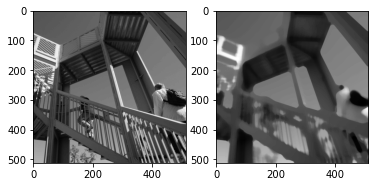

In [36]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.median_filter(ascent, size=20)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()